In [1]:
from IPython.core.display import display, HTML
from warnings import filterwarnings
display(HTML("<style>.container { width:100% !important; }</style>"))
# filterwarnings(action='ignore')

In [2]:
# conda
import numpy as np
import scipy.stats as ss
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
from sklearn.model_selection import KFold

from fitter import Fitter

# pip
from evalys.workload import Workload


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
input_location = '../../swf/METACENTRUM-2013-3.swf'

In [4]:
workload = Workload.from_csv(input_location)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
workload.df

,jobID,submission_time,waiting_time,execution_time,proc_alloc,cpu_used,mem_used,proc_req,user_est,mem_req,status,uid,gid,exe_num,queue,partition,prev_jobs,think_time
0,2,5,2,1053,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
1,3,6,6,928,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
2,4,6,9,778,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
3,5,7,15,809,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,21,-1,-1
4,6,10,15,1177,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,21,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731094,5731096,62985547,105400,37737,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,13,-1,-1
5731095,5731097,62985548,105404,27914,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,22,-1,-1
5731096,5731098,62985548,105496,16844,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,5,-1,-1
5731097,5731099,62985553,105495,36524,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,13,-1,-1


In [6]:
# dataframe with processors requests and memory requests, removed -1 and 0 values
df = workload.df
print(df.shape)
df = df[df.mem_req > 0]
print(df.shape)
df = df[df.proc_req > 0]
print(df.shape)
# df = df[df.execution_time > 1]
# print(df.shape)
df = df[['proc_req', 'mem_req']]
print(df.shape)

(5731099, 18)
(5722091, 18)
(5722091, 18)
(5722091, 2)


In [7]:
# Series of memory requests
mem_req = df['mem_req']
print(mem_req.size)
# mem_req = mem_req[mem_req > 0]
# print(mem_req.size)

5722091


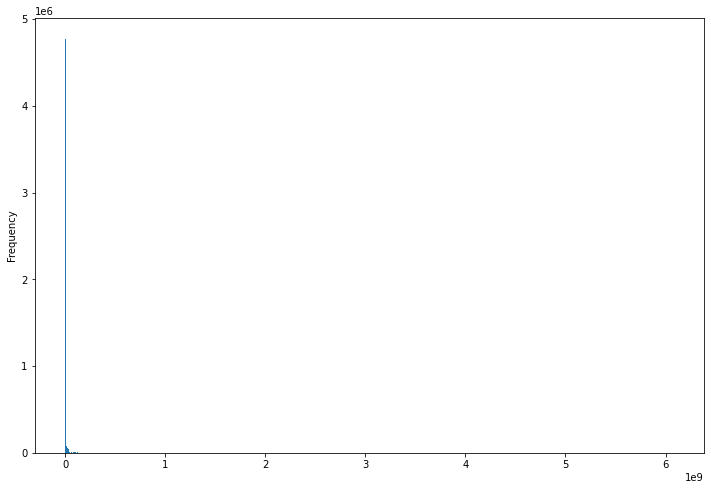

In [45]:
# memory linear histogram
mem_req.plot(kind='hist', bins=1000, loglog=False)

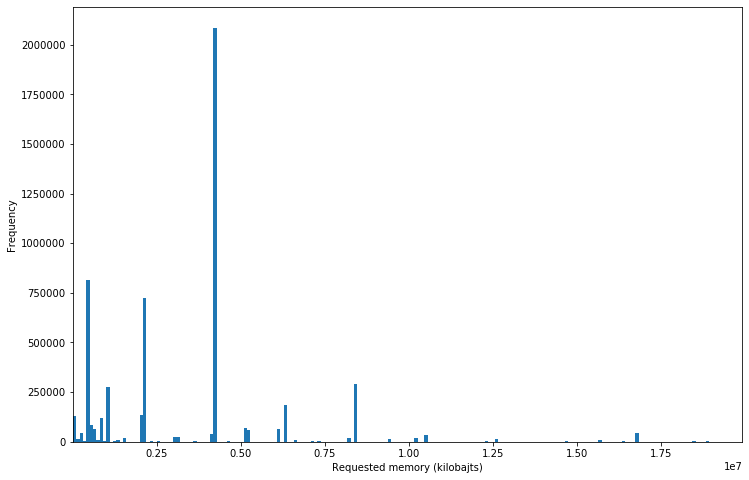

In [240]:
# memory linear histogram
mem_hist_lim = mem_req[mem_req <= 2*10**7]
# mem_hist_lim.plot(kind='hist', bins=200)
mem_hist_lim.plot(kind='hist', bins=200, xlim=(mem_hist_lim.min(), mem_hist_lim.max()))
plt.xlabel('Requested memory (kilobajts)')
plt.savefig('../../images/truncated_memory_requests_histogram.pdf', bbox_inches='tight')

In [12]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

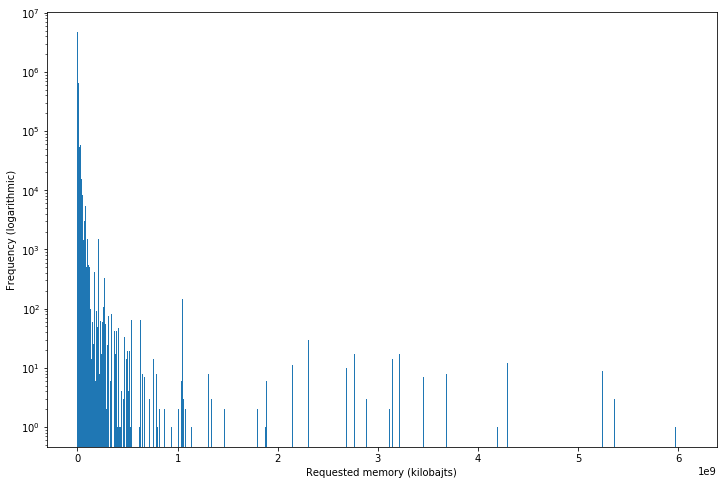

In [18]:
# memory histogram with log y axis with counts
mem_req.plot(kind='hist', bins=1000, logy=True)
plt.xlabel('Requested memory (kilobajts)')
plt.ylabel('Frequency (logarithmic)')
# plt.savefig('../../images/memory_requests_histogram.png', dpi=300, transparent=True, bbox_inches='tight')
# plt.savefig('../../images/memory_requests_histogram.pgf')
plt.savefig('../../images/memory_requests_histogram.pdf')

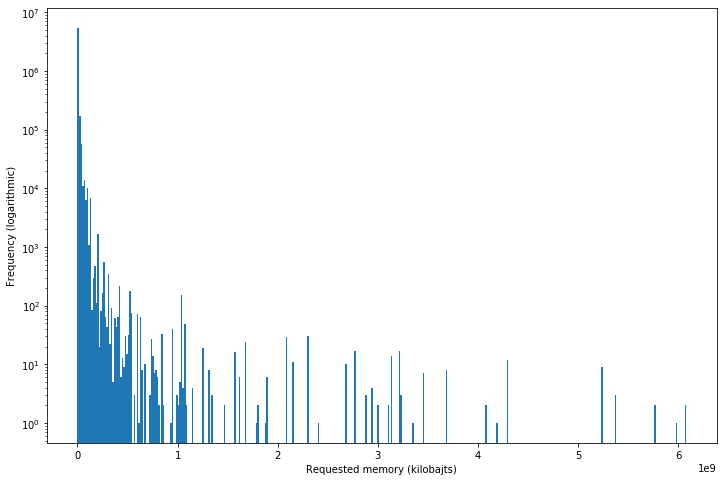

In [61]:
# memory histogram with log y axis with counts
# mem_req.plot(kind='hist', bins=400, logy=True, xlim=(mem_req.min(), mem_req.max()))
mem_req.plot(kind='hist', bins=400, logy=True)
plt.xlabel('Requested memory (kilobajts)')
plt.ylabel('Frequency (logarithmic)')
plt.savefig('../../images/memory_requests_histogram.pdf', bbox_inches='tight')

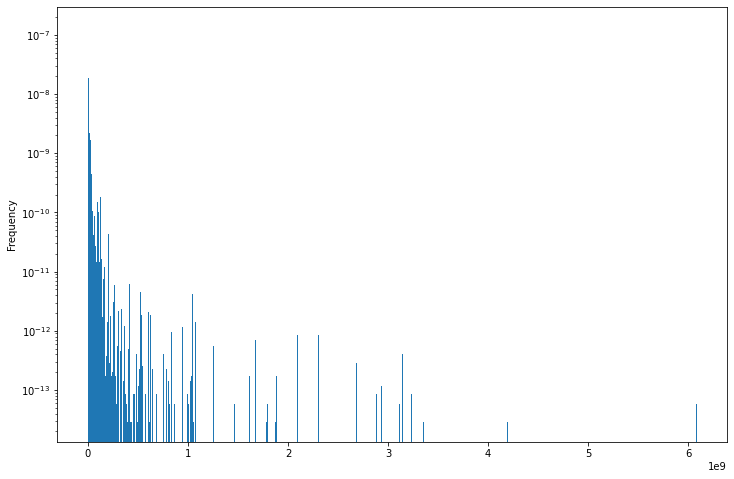

In [47]:
# memory histogram with log y axis with probability
mem_req.plot(kind='hist', density=True, bins=1000, logy=True)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


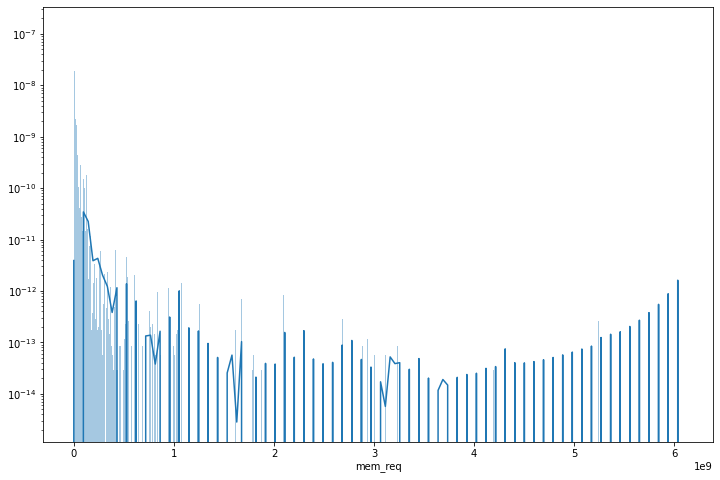

In [48]:
# Seaborn histogram with probability, log y axis, seems to truncate values of prob above 10**-25, kernel density estimation
ax = sns.distplot(mem_req, bins=1000, hist_kws={'log':True})
# ax.set_xscale('log')

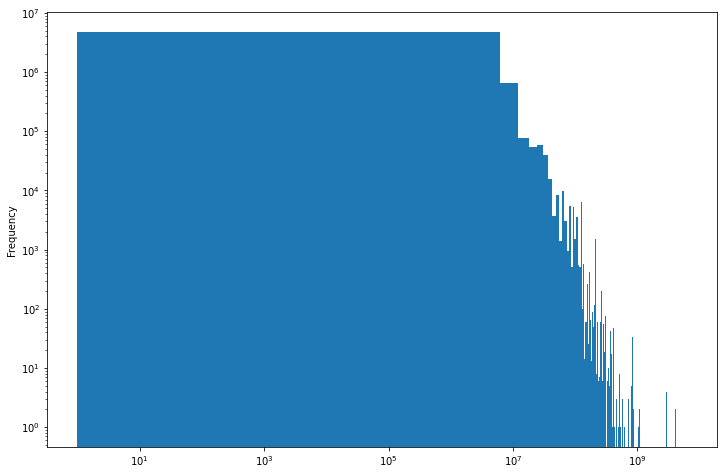

In [49]:
# log log histogram with counts
mem_req.plot(kind='hist', bins=1000, loglog=True)

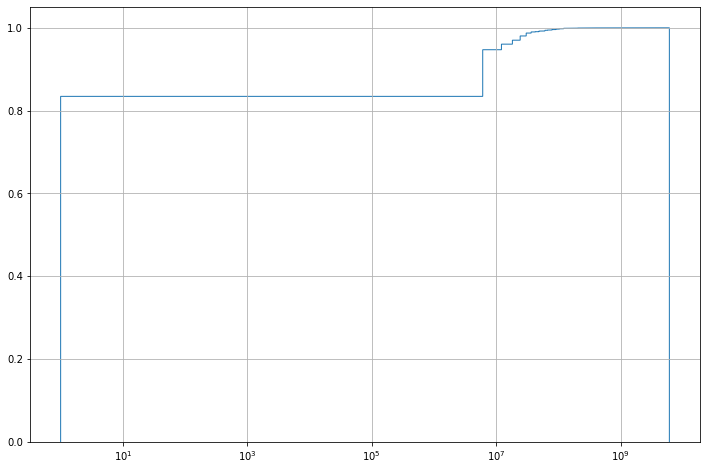

In [64]:
# cdf of mem with log x axis
ax = mem_req.hist(cumulative=True, density=True, bins=1000, histtype='step')
ax.set_xscale('log')

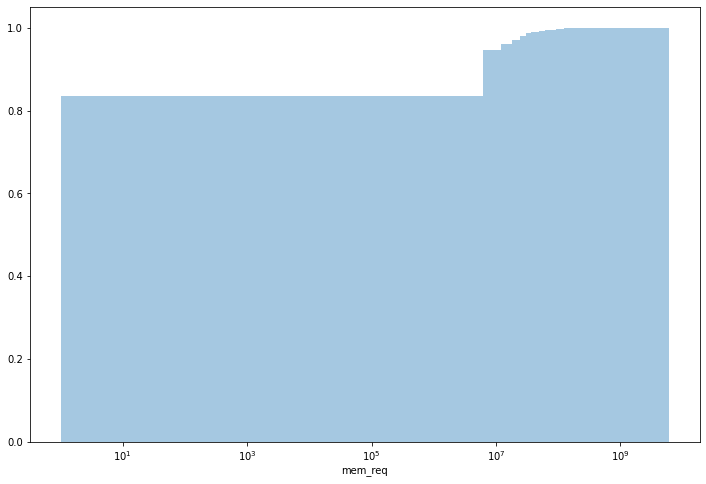

In [51]:
# same as above
ax = sns.distplot(mem_req, kde=False, bins=1000, hist_kws={'cumulative':True, 'density':True})
ax.set_xscale('log')

In [52]:
# mem metrics
mem_req.describe()

count    5.722091e+06
mean     5.192453e+06
std      2.438858e+07
min      1.000000e+00
25%      1.048576e+06
50%      4.194304e+06
75%      4.194304e+06
max      6.081741e+09
Name: mem_req, dtype: float64

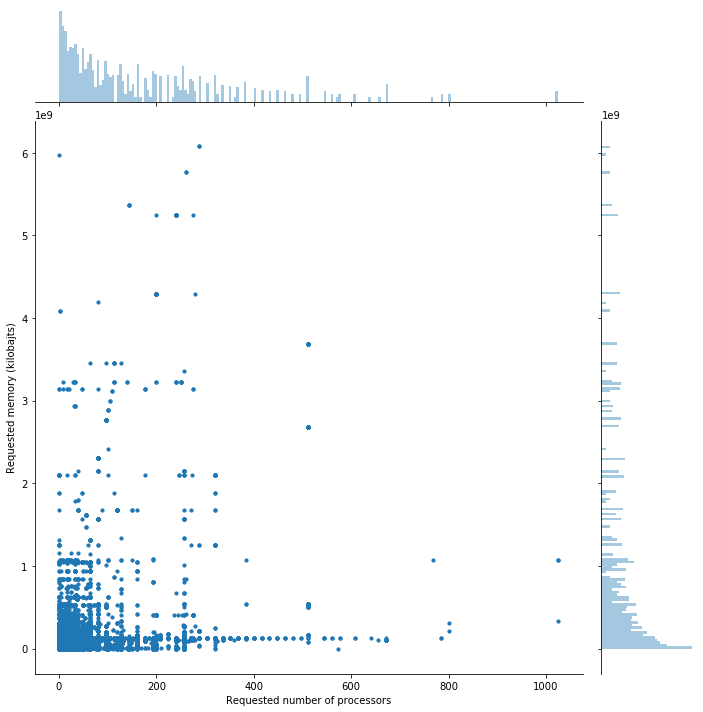

In [76]:
# linear scatter jointplot
# joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=8, marginal_kws=dict(bins=1000))
# joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=10, marginal_kws={'bins':200,'hist_kws':{'log': True}})
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=10, s=10, marginal_kws={'bins':200,'hist_kws':{'log': True}})
joint_proc_mem.set_axis_labels('Requested number of processors', 'Requested memory (kilobajts)')
plt.savefig('../../images/scatterplot.png', dpi=300)
# plt.savefig('../../images/scatterplot.pdf', format='pdf', dpi=300, bbox_inches='tight')

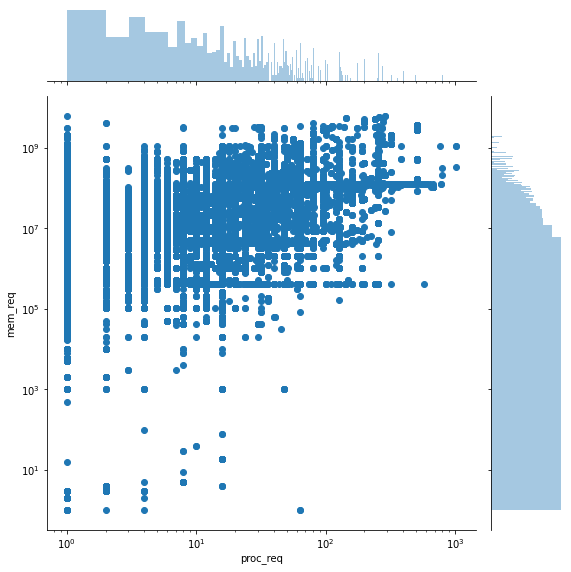

In [55]:
# log log scatter, marginal distribution
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=8, marginal_kws={'bins':1000,'hist_kws':{'log': True}})
joint_proc_mem.ax_joint.set_yscale('log')
joint_proc_mem.ax_joint.set_xscale('log')

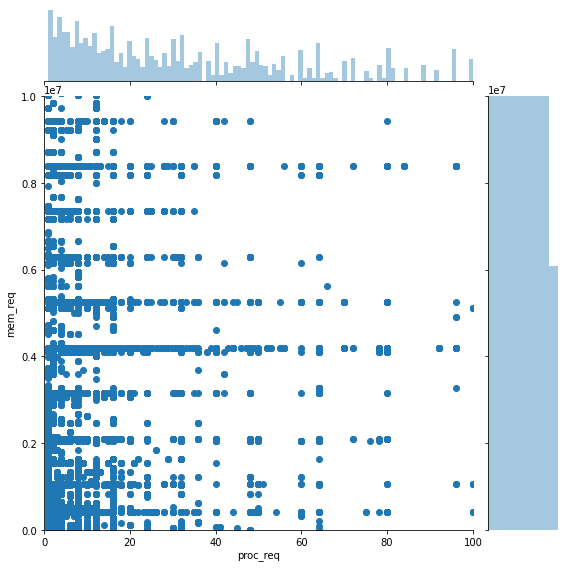

In [66]:
# linear scatter with limits
sns.jointplot(x='proc_req', y='mem_req', data=df, kind='scatter', height=8, ylim=(0,10**7), xlim=(0,10**2), marginal_kws={'bins':1000,'hist_kws':{'log': True}})

In [78]:
# dataframe limited and sampled
plot_sample = df[df.proc_req < 100]
plot_sample = plot_sample[plot_sample.mem_req < 10**7]
plot_sample = plot_sample.sample(n=1000)
plot_sample.shape

(1000, 2)

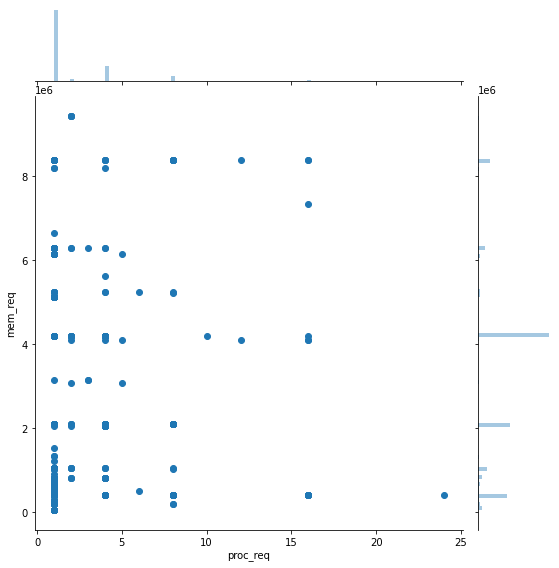

In [71]:
# scatter with samples
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=plot_sample, kind='scatter', height=8, marginal_kws=dict(bins=100))
# joint_proc_mem.ax_joint.set_yscale('log')
# joint_proc_mem.ax_joint.set_xscale('log')

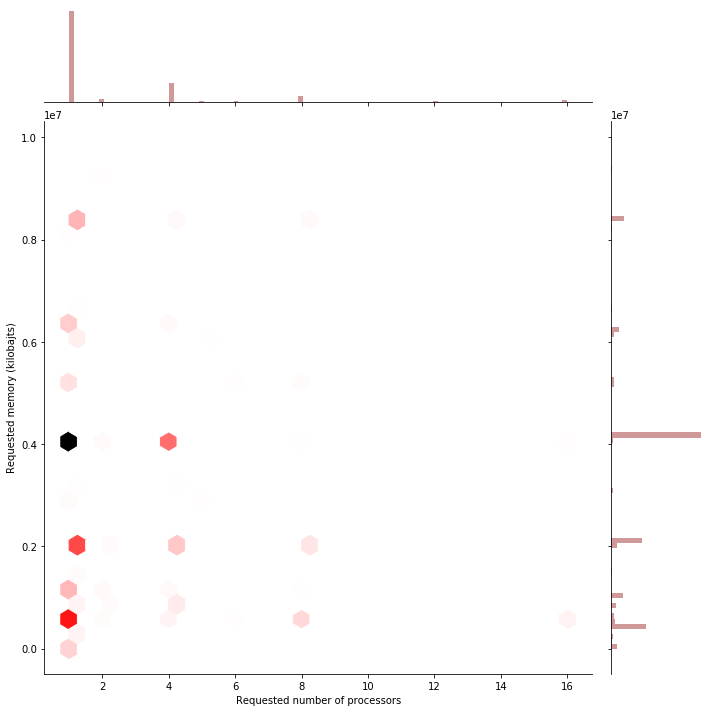

In [113]:
# hex scatter with samples
plot_sample_hex = df[df.proc_req <= 16]
plot_sample_hex = plot_sample_hex[plot_sample_hex.mem_req <= 10**7]
# plot_sample_hex = plot_sample_hex.sample(n=1000)
# joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=plot_sample, kind='hex', height=8, marginal_kws=dict(bins=100))
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=plot_sample_hex, kind='hex', height=10, marginal_kws=dict(bins=100), joint_kws={'gridsize':30}, color='darkred')
joint_proc_mem.set_axis_labels('Requested number of processors', 'Requested memory (kilobajts)')
joint_proc_mem.savefig('../../images/heatmap.png', dpi=300)

In [168]:
# 409600 = 400 MB. Why did I check this value???
# df[df.mem_req > 309600][df.mem_req < 509600]['mem_req'].hist(bins=100)
df[df.mem_req == 409600]['mem_req']
805516 / 5722091

0.14077301462000516

In [178]:
# 14% of probability mass is concentrated on 4GB
# df[df.mem_req > 3*1024*1024][df.mem_req < 5*1024*1024]['mem_req']
# 2210992 / 5722091
df[df.mem_req == 4*1024*1024]['mem_req']
2085360 / 5722091

0.36444020201705984

In [60]:
covariance = df.cov().iloc[0,1]
proc_std = df.std()[0]
mem_std = df.std()[1]

In [61]:
correlation_coefficient = covariance / (proc_std * mem_std)
correlation_coefficient

0.3450583483172327

In [62]:
# very wear linear correlation 
df.corr(method='pearson')

,proc_req,mem_req
proc_req,1.000000,0.345058
mem_req,0.345058,1.000000


In [63]:
# no correlation 
df.corr(method='kendall')

,proc_req,mem_req
proc_req,1.00000,0.07337
mem_req,0.07337,1.00000


In [64]:
# no correlation 
df.corr(method='spearman')

,proc_req,mem_req
proc_req,1.000000,0.087583
mem_req,0.087583,1.000000


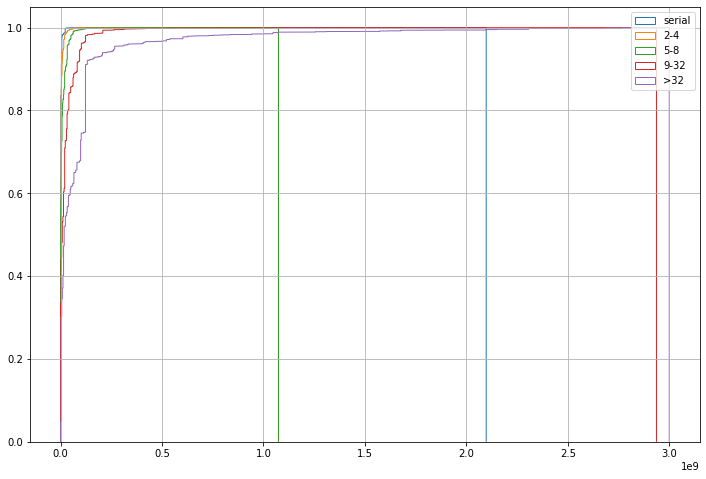

In [65]:
# very weak correlation
cdf_df = df[df.mem_req < 3 * 10**9]
cdf = cdf_df[cdf_df.proc_req == 1]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='serial')
cdf_df[(cdf_df.proc_req > 1) & (cdf_df.proc_req <= 4)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='2-4')
cdf_df[(cdf_df.proc_req > 4) & (cdf_df.proc_req <= 8)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='5-8')
cdf_df[(cdf_df.proc_req > 8) & (cdf_df.proc_req <= 32)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='9-32')
cdf_df[cdf_df.proc_req > 32]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='>32')
cdf.legend()

In [27]:
# fig, ax = plt.subplots()
print(df[df.proc_req == 1]['mem_req'].std())
print(df[(df.proc_req > 1) & (df.proc_req <= 4)]['mem_req'].std())
print(df[(df.proc_req > 4) & (df.proc_req <= 8)]['mem_req'].std())
print(df[(df.proc_req > 8) & (df.proc_req <= 32)]['mem_req'].std())
print(df[df.proc_req > 32]['mem_req'].std())

7342164.208985007
10236134.325274887
19297272.241043024
59108527.715613075
355881077.43252635


1
2
3
4
5
6
10


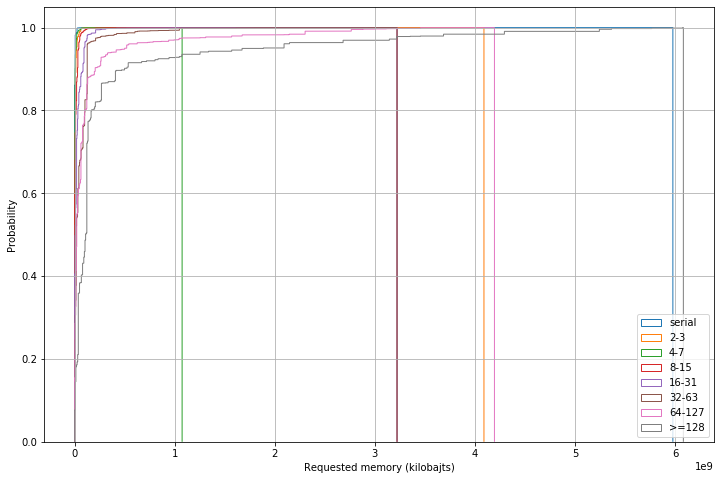

In [125]:
df[df.proc_req == 1]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='serial')
for i in range(1, 7):
    print(i)
    left = 2**i
    right = 2**(i+1)
    df[(df.proc_req >= left) & (df.proc_req < right)]['mem_req'].hist(
        cumulative=True, density=True, bins=1000, histtype='step', label='{}-{}'.format(left, right-1))
print(10)
df[df.proc_req >= 2**7]['mem_req'].hist(
    cumulative=True, density=True, bins=1000, histtype='step', label='>={}'.format(2**7, None))
plt.xlabel('Requested memory (kilobajts)')
plt.ylabel('Probability')
plt.legend(loc='lower right')
plt.savefig('../../images/cdf_ranges_many.pdf', bbox_inches='tight')

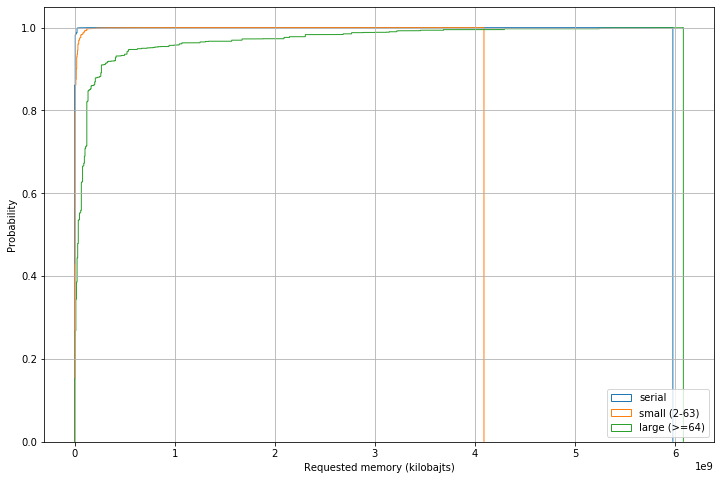

In [139]:
fig, ax = plt.subplots()
# ax.set_xlim(right=4*10**9)
df[df.proc_req == 1]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='serial')
df[(df.proc_req > 1) & (df.proc_req < 64)]['mem_req'].hist(
    cumulative=True, density=True, bins=1000, histtype='step', label='small (2-63)')
df[df.proc_req >= 64]['mem_req'].hist(
    cumulative=True, density=True, bins=1000, histtype='step', label='large (>=64)')
plt.xlabel('Requested memory (kilobajts)')
plt.ylabel('Probability')
plt.legend(loc='lower right')
plt.savefig('../../images/cdf_ranges_few.pdf', bbox_inches='tight')

In [26]:
mem_limit = 5*10**7
mem_lim = mem_req[mem_req <= mem_limit]

In [27]:
loc_expon, scale_expon = ss.expon.fit(mem_req)
loc_expon, scale_expon

(1.0, 5192451.526500191)

In [38]:
x = np.linspace(mem_lim.min(), mem_lim.max(), 10000)
y_pdf_expon = ss.expon.pdf(x, loc=loc_expon, scale=scale_expon)
y_cdf_expon = ss.expon.cdf(x, loc=loc_expon, scale=scale_expon)

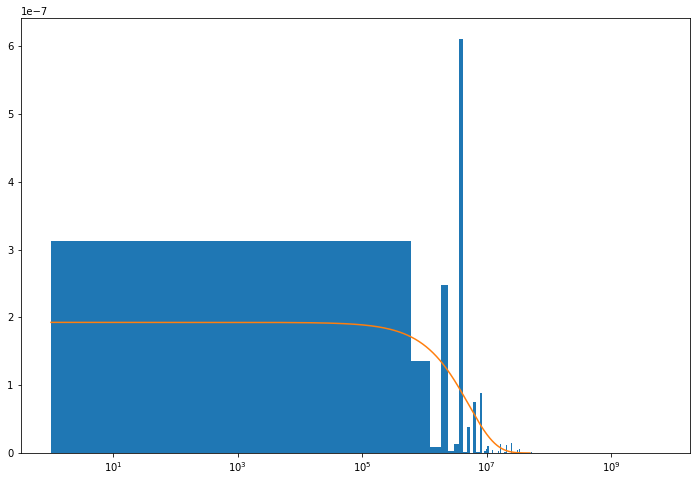

In [21]:
fig, ax = plt.subplots()
ax.set_xscale('log')
# ax.set_yscale('log')
ax.hist(mem_req, bins=10000, density=True)
ax.plot(x, y_pdf_expon)

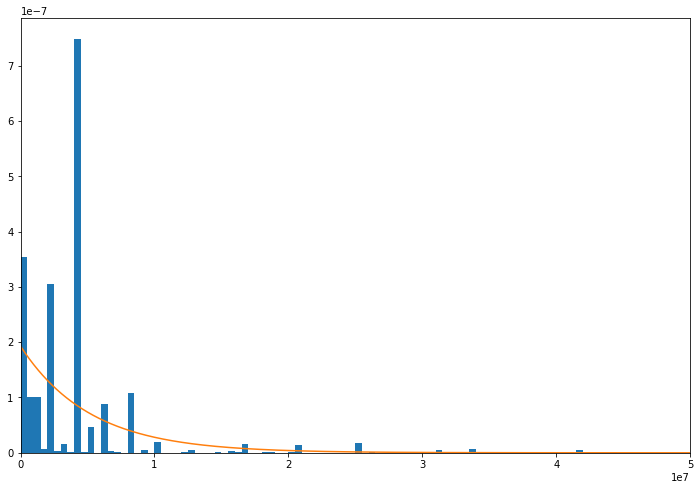

In [22]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_expon)

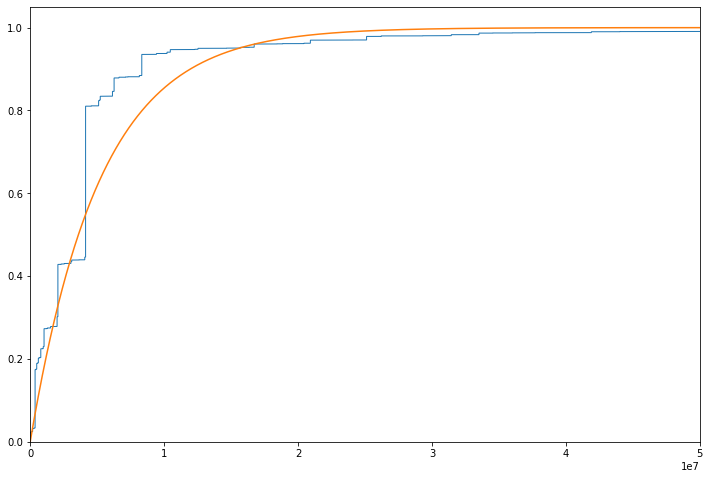

In [23]:
fig, ax = plt.subplots()
# ax.set_xscale('log')
ax.set_xlim(right=mem_limit)
ax.hist(mem_req, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_expon)

In [501]:
a, loc, scale = ss.erlang.fit(mem_req)
a, loc, scale

(0.766769360472922, -124.93246258643205, 6779660.97506615)

In [502]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.erlang.pdf(x, a=a, loc=loc, scale=scale)
y_cdf = ss.erlang.cdf(x, a=a, loc=loc, scale=scale)

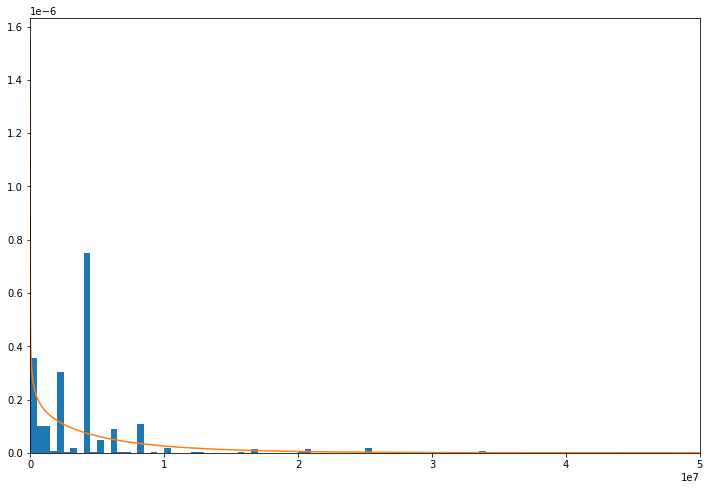

In [503]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

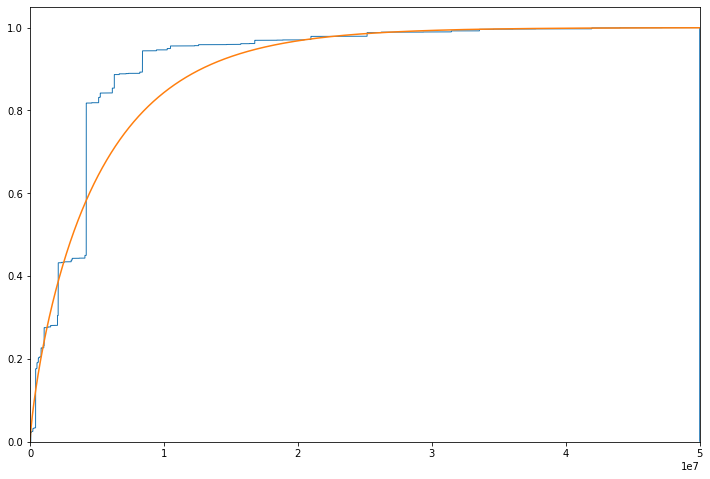

In [504]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [505]:
a, loc, scale = ss.gamma.fit(mem_req)
a, loc, scale

(0.000863742316364836, 6313536772.269705, 7.121602910510014e-24)

In [506]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.gamma.pdf(x, a=a, loc=loc, scale=scale)
y_cdf = ss.gamma.cdf(x, a=a, loc=loc, scale=scale)

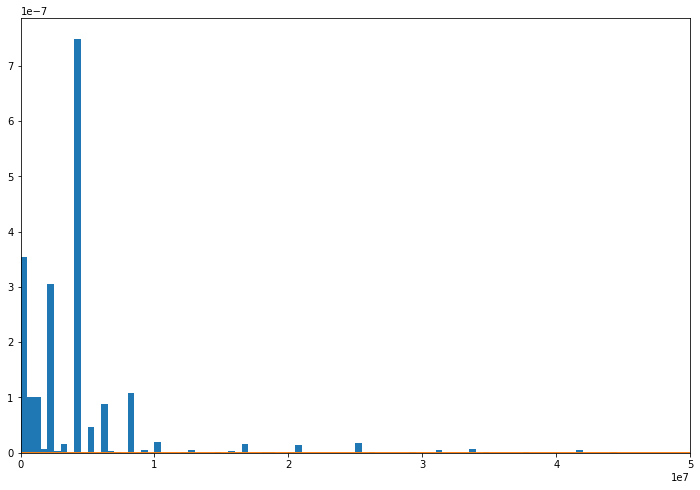

In [507]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

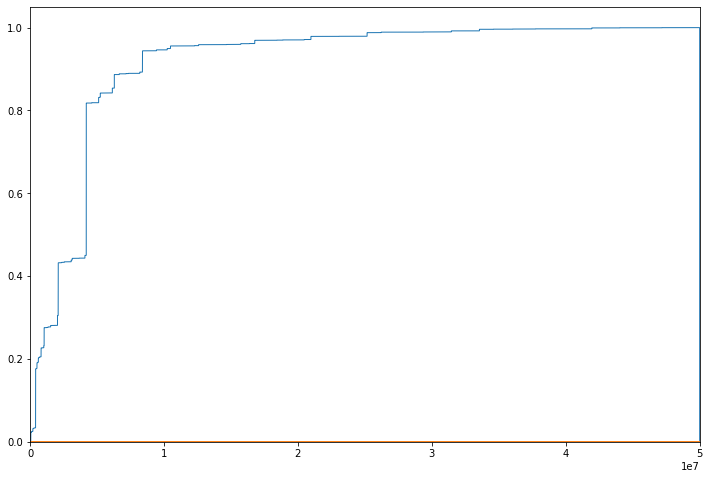

In [509]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [510]:
c, loc, scale = ss.weibull_min.fit(mem_req)
c, loc, scale

(0.7999279430881769, 0.9999999999999999, 4358866.223776371)

In [511]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.weibull_min.pdf(x, c=c, loc=loc, scale=scale)
y_cdf = ss.weibull_min.cdf(x, c=c, loc=loc, scale=scale)

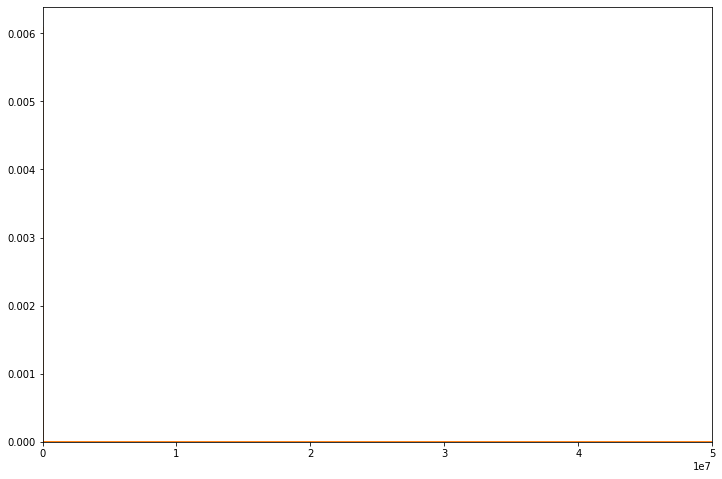

In [515]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

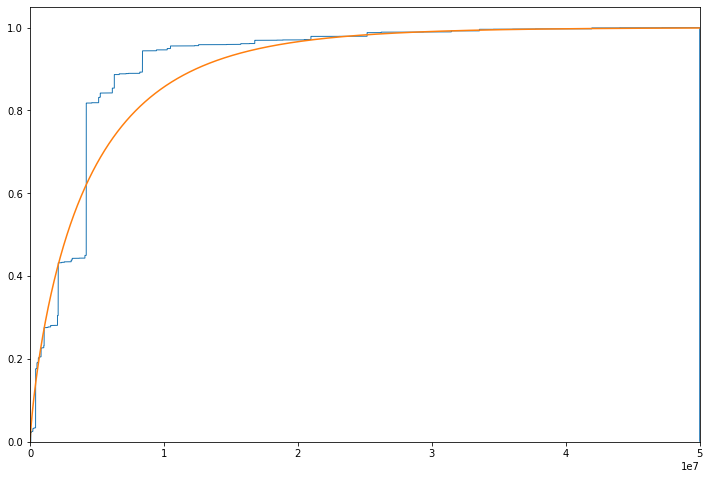

In [514]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [516]:
b, loc, scale = ss.pareto.fit(mem_req)
b, loc, scale

(0.07258365920045476, -1.529464864041959, 2.5294644620914735)

In [517]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.pareto.pdf(x, b=b, loc=loc, scale=scale)
y_cdf = ss.pareto.cdf(x, b=b, loc=loc, scale=scale)

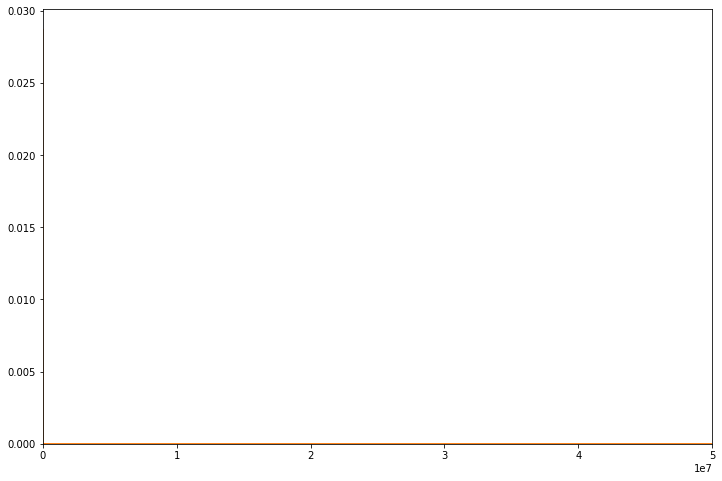

In [518]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

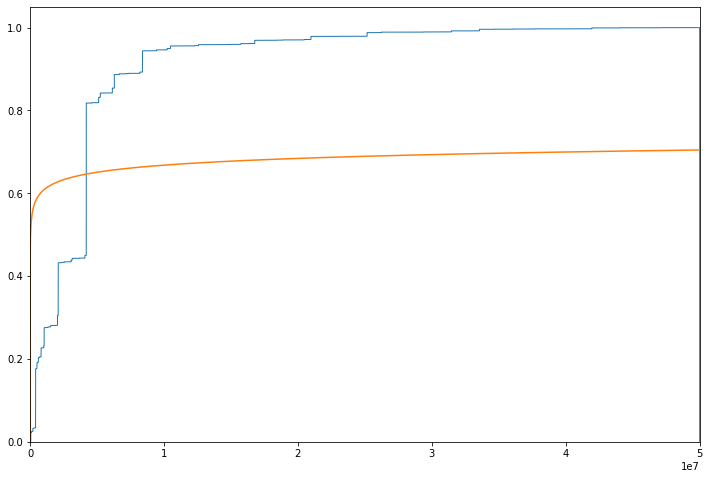

In [519]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [20]:
s_lognorm, loc_lognorm, scale_lognorm = ss.lognorm.fit(mem_req)
s_lognorm, loc_lognorm, scale_lognorm

(1.0972517799795216, -150361.3304133251, 2714115.097037774)

In [40]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf_lognorm = ss.lognorm.pdf(x, s=s_lognorm, loc=loc_lognorm, scale=scale_lognorm)
y_cdf_lognorm = ss.lognorm.cdf(x, s=s_lognorm, loc=loc_lognorm, scale=scale_lognorm)

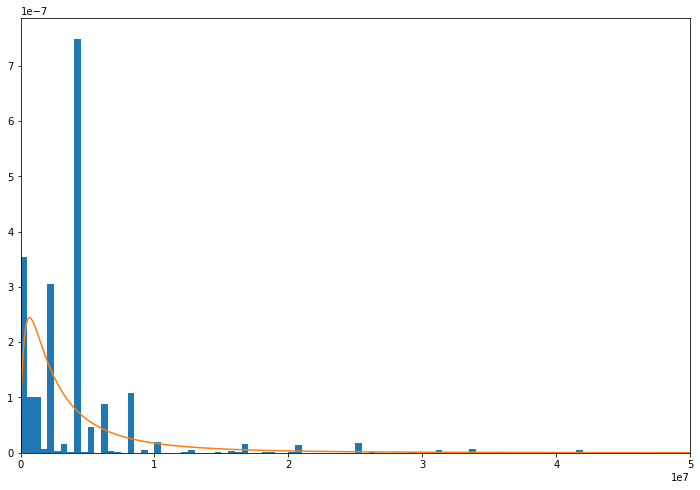

In [41]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_lognorm)

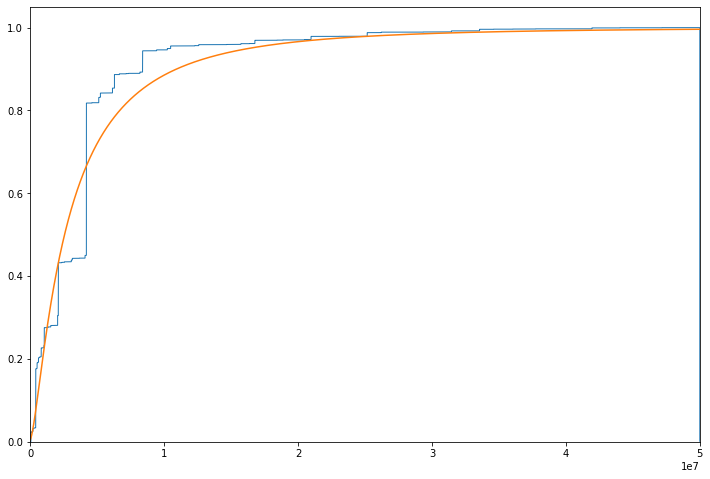

In [42]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_lognorm)

In [24]:
fit_sample = mem_req.sample(n=10000)

In [77]:
fitter = Fitter(fit_sample)
fitter.fit()

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=8.202826926459685e-15)
Fitted anglit distribution with error=7.841652943590325e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=7.531569328981128e-15)
Fitted argus distribution with error=8.137477206081744e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=7.652038215126244e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:712: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=8.057742767289334e-15)
Fitted bradford distribution with error=7.0153623217720885e-15)
Fitted burr distribution with error=7.474815157693402e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:951: RuntimeWarning: overflow encountered in power
  return np.log(c) + np.log(d) + sc.xlogy(c - 1, x) + sc.xlog1py(-d-1, x**c)


Fitted burr12 distribution with error=8.057861822905412e-15)
Fitted cauchy distribution with error=8.202893645609877e-15)
Fitted chi distribution with error=3.2977333243858113e-15)
Fitted chi2 distribution with error=2.9371262874009695e-15)
Fitted cosine distribution with error=7.738911507335927e-15)
Fitted crystalball distribution with error=4.0959891768683885e-15)
Fitted dgamma distribution with error=6.8865970147113535e-15)
Fitted dweibull distribution with error=5.662340437966986e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/s

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.312092870664597.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.3108367594977052.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.3100140159716269.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.31231786482372903.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8

Fitted erlang distribution with error=7.817988159022954e-15)
Fitted expon distribution with error=1.7063187431134527e-15)
Fitted exponnorm distribution with error=1.7327693074086646e-15)
Fitted exponpow distribution with error=4.206342324574536e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1607: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


Fitted exponweib distribution with error=7.652584035112869e-15)
Fitted f distribution with error=8.203443181458486e-15)
Fitted fatiguelife distribution with error=4.6459497506716154e-15)
Fitted fisk distribution with error=7.168290047481173e-15)
Fitted foldcauchy distribution with error=8.204519176919832e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted foldnorm distribution with error=2.944791565802072e-15)
Fitted frechet_l distribution with error=8.209074926168048e-15)
Fitted frechet_r distribution with error=4.441155618116051e-15)
Fitted gamma distribution with error=8.204932365144624e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=5.919521919507197e-15)
Fitted genexpon distribution with error=1.7063186687710308e-15)
Fitted genextreme distribution with error=7.748594884750062e-15)
Fitted gengamma distribution with error=6.564474519494806e-15)
Fitted genhalflogistic distribution with error=5.190590122877682e-16)
Fitted geninvgauss distribution with error=7.832950577808346e-15)
Fitted genlogistic distribution with error=1.4212383355865975e-15)
Fitted gennorm distribution with error=7.924725267927767e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=8.1654125433106e-15)
Fitted gilbrat distribution with error=5.970298684684246e-15)
Fitted gompertz distribution with error=1.7184881933463623e-15)
Fitted gumbel_l distribution with error=7.786314457427436e-15)
Fitted gumbel_r distribution with error=1.429522143595245e-15)
Fitted halfcauchy distribution with error=8.200797392616957e-15)
Fitted halfgennorm distribution with error=5.456885086580999e-15)
Fitted halflogistic distribution with error=5.238569216514197e-16)
Fitted halfnorm distribution with error=1.9872361449345473e-15)
Fitted hypsecant distribution with error=2.0914121219688992e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3322: RuntimeWarning: overflow encountered in cosh
  return 1.0/(np.pi*np.cosh(x))


Fitted invgamma distribution with error=8.201649040738759e-15)
Fitted invgauss distribution with error=8.204003260453415e-15)
Fitted invweibull distribution with error=7.649493677604697e-15)
Fitted johnsonsb distribution with error=7.527862620887185e-15)
Fitted johnsonsu distribution with error=8.2047280264482e-15)
Fitted kappa3 distribution with error=7.66737490696742e-15)
Fitted kappa4 distribution with error=8.037593268376015e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:97: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=8.11828056513028e-15)
Fitted kstwobign distribution with error=2.3731407995945657e-15)
Fitted laplace distribution with error=4.344071261135436e-15)
Fitted levy distribution with error=8.204932364893122e-15)
Fitted levy_l distribution with error=8.173219018614584e-15)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED loggamma distribution (taking more than 30 seconds)
Fitted logistic distribution with error=1.2519278717443535e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


Fitted loglaplace distribution with error=7.592092307982686e-15)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitted loguniform distribution with error=8.204932365144624e-15)
Fitted lomax distribution with error=8.203893914485755e-15)
Fitted maxwell distribution with error=3.601872549856013e-15)
SKIPPED mielke distribution (taking more than 30 seconds)
Fitted moyal distribution with error=1.9594734001457654e-15)
SKIPPED nakagami distribution (taking more than 30 seconds)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


SKIPPED ncf distribution (taking more than 30 seconds)
SKIPPED nct distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
Fitted norm distribution with error=3.916893450314755e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5836: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5832: RuntimeWarning: overflow encountered in multiply
  trm1 = np.sqrt(2)*nc*x*sc.hyp1f1(n/2+1, 1.5, valF)


Fitted norminvgauss distribution with error=8.199120636787857e-15)
SKIPPED pareto distribution (taking more than 30 seconds)
SKIPPED pearson3 distribution (taking more than 30 seconds)
SKIPPED powerlaw distribution (taking more than 30 seconds)
SKIPPED powerlognorm distribution (taking more than 30 seconds)
SKIPPED powernorm distribution (taking more than 30 seconds)
Fitted rayleigh distribution with error=2.6114820022856807e-15)
SKIPPED rdist distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
Fitted reciprocal distribution with error=8.204932365144624e-15)
SKIPPED rice distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=7.91152757045479e-15)
SKIPPED skewnorm distribution (taking more than 30 seconds)
Fitted t distribution with error=8.151227588661642e-15)
Fitted trapz

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7248: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


SKIPPED tukeylambda distribution (taking more than 30 seconds)
Fitted uniform distribution with error=8.118196191184226e-15)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitted wald distribution with error=4.239644431915397e-15)
Fitted weibull_max distribution with error=8.209074926168048e-15)
Fitted weibull_min distribution with error=4.441155618116051e-15)
Fitted wrapcauchy distribution with error=nan)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [85]:
# Error, took whole df
pd.options.display.max_rows = 100
fitter.summary(Nbest=100, plot=False, method='sumsquare_error')

,sumsquare_error,aic,bic,kl_div
genhalflogistic,5.190590e-16,5.143141e+04,-9.019303e+05,inf
halflogistic,5.238569e-16,5.112316e+04,-9.017562e+05,inf
logistic,1.251928e-15,5.623114e+04,-8.843318e+05,inf
genlogistic,1.421238e-15,5.078051e+04,-8.817850e+05,inf
gumbel_r,1.429522e-15,5.090287e+04,-8.816787e+05,inf
genexpon,1.706319e-15,4.387512e+04,-8.781090e+05,inf
expon,1.706319e-15,4.386912e+04,-8.781387e+05,inf
gompertz,1.718488e-15,4.398730e+04,-8.779867e+05,inf
exponnorm,1.732769e-15,4.406852e+04,-8.778212e+05,inf
moyal,1.959473e-15,4.659866e+04,-8.753720e+05,inf


In [25]:
fitter = Fitter(fit_sample)
fitter.fit()

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=7.711701413385438e-15)
Fitted anglit distribution with error=7.546127926873261e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=7.081794570886392e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7953: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted argus distribution with error=7.658683603466018e-15)
Fitted beta distribution with error=4.455168362809993e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:712: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=1.013093007379661e-15)
Fitted bradford distribution with error=6.4265479657533454e-15)
Fitted burr distribution with error=9.910542008853185e-16)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:951: RuntimeWarning: overflow encountered in power
  return np.log(c) + np.log(d) + sc.xlogy(c - 1, x) + sc.xlog1py(-d-1, x**c)


Fitted burr12 distribution with error=6.659925108500537e-15)
Fitted cauchy distribution with error=7.845329317828104e-17)
Fitted chi distribution with error=3.366176722013174e-15)
Fitted chi2 distribution with error=3.764965675353822e-15)
Fitted cosine distribution with error=7.455324246184687e-15)
Fitted crystalball distribution with error=5.14693010596778e-15)
Fitted dgamma distribution with error=2.4385360790555595e-16)
Fitted dweibull distribution with error=2.0966282450470902e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/s

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.9618553267661158.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.7483223714647309.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.48132928092204796.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.4503856474315615.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.

Fitted erlang distribution with error=1.0444349077123955e-15)
Fitted expon distribution with error=4.24289205186518e-16)
Fitted exponnorm distribution with error=4.0938226866646707e-16)
Fitted exponpow distribution with error=4.5031332104868105e-15)
Fitted exponweib distribution with error=1.2787600602006453e-15)
Fitted f distribution with error=3.5633887731670075e-15)
Fitted fatiguelife distribution with error=1.4978961651625632e-15)
Fitted fisk distribution with error=1.1997392217304076e-15)
Fitted foldcauchy distribution with error=3.666024745933003e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted foldnorm distribution with error=4.491416967525408e-15)
Fitted frechet_l distribution with error=7.729606243306082e-15)
Fitted frechet_r distribution with error=1.4168211178914705e-15)
Fitted gamma distribution with error=7.725517317684671e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=4.9019829196714034e-15)
Fitted genexpon distribution with error=4.2428921162928386e-16)
Fitted genextreme distribution with error=7.112169121373558e-15)
Fitted gengamma distribution with error=1.2295144374287224e-15)
Fitted genhalflogistic distribution with error=6.638225628319383e-17)
Fitted geninvgauss distribution with error=1.0829743124189309e-15)
Fitted genlogistic distribution with error=2.624406515334094e-17)
Fitted gennorm distribution with error=3.4681311950312737e-16)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=1.1156752601097087e-15)
Fitted gilbrat distribution with error=9.767829141554382e-16)
Fitted gompertz distribution with error=4.3045038590629286e-16)
Fitted gumbel_l distribution with error=7.371016743868332e-15)
Fitted gumbel_r distribution with error=2.5819536855867168e-17)
Fitted halfcauchy distribution with error=1.5963637643981771e-15)
Fitted halfgennorm distribution with error=1.5812319386759071e-15)
Fitted halflogistic distribution with error=6.687195724775728e-17)
Fitted halfnorm distribution with error=3.7547639007156645e-15)
Fitted hypsecant distribution with error=6.053470654624679e-17)
Fitted invgamma distribution with error=1.074536044314608e-15)
Fitted invgauss distribution with error=1.6031753556819679e-15)
Fitted invweibull distribution with error=1.0512640411409856e-15)
Fitted johnsonsb distribution with error=8.255235325586387e-16)
Fitted johnsonsu distribution with error=1.2831692242189427e-15)
Fitted kappa3 distribution with 

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:97: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=7.638865517341648e-15)
Fitted kstwobign distribution with error=3.958388095467677e-15)
Fitted laplace distribution with error=6.023985217085621e-17)
Fitted levy distribution with error=3.148238278715412e-15)
Fitted levy_l distribution with error=7.693986608178716e-15)
SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=5.054915518782898e-15)
Fitted logistic distribution with error=1.3083628397853231e-16)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=1.5452962826644691e-16)
Fitted lognorm distribution with error=1.2821265789543692e-15)
Fitted loguniform distribution with error=7.725517317684671e-15)
Fitted lomax distribution with error=1.1174310748338786e-15)
Fitted maxwell distribution with error=4.9539202491017255e-15)
SKIPPED mielke distribution (taking more than 30 seconds)
Fitted moyal distribution with error=4.679948665909171e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5544: RuntimeWarning: divide by zero encountered in power
  return 2*nu**nu/sc.gamma(nu)*(x**(2*nu-1.0))*np.exp(-nu*x*x)


Fitted nakagami distribution with error=3.749465123183218e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


SKIPPED ncf distribution (taking more than 30 seconds)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5836: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5832: RuntimeWarning: overflow encountered in multiply
  trm1 = np.sqrt(2)*nc*x*sc.hyp1f1(n/2+1, 1.5, valF)


SKIPPED nct distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
Fitted norm distribution with error=5.12458531151645e-15)
SKIPPED norminvgauss distribution (taking more than 30 seconds)
Fitted pareto distribution with error=6.907145582957036e-15)
SKIPPED pearson3 distribution (taking more than 30 seconds)
Fitted powerlaw distribution with error=5.795908042992381e-15)
SKIPPED powerlognorm distribution (taking more than 30 seconds)
SKIPPED powernorm distribution (taking more than 30 seconds)
Fitted rayleigh distribution with error=4.197585381489845e-15)
SKIPPED rdist distribution (taking more than 30 seconds)
Fitted recipinvgauss distribution with error=1.1635283118470016e-15)
Fitted reciprocal distribution with error=7.725517317684671e-15)
Fitted rice distribution with error=4.876193771951169e-15)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircu

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7248: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


SKIPPED tukeylambda distribution (taking more than 30 seconds)
Fitted uniform distribution with error=7.638781143401153e-15)
Fitted vonmises distribution with error=0.04595109630305103)
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitted wald distribution with error=7.022131624787533e-16)
Fitted weibull_max distribution with error=7.729606243306082e-15)
SKIPPED weibull_min distribution (taking more than 30 seconds)
Fitted wrapcauchy distribution with error=nan)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [26]:
pd.options.display.max_rows = 100
fitter.summary(Nbest=100, plot=False, method='sumsquare_error')

,sumsquare_error,aic,bic,kl_div
dweibull,2.096628e-17,1.067866e+04,-4.761119e+05,inf
t,2.581272e-17,5.911598e+03,-4.740324e+05,inf
gumbel_r,2.581954e-17,3.402981e+04,-4.740390e+05,inf
genlogistic,2.624407e-17,3.407693e+04,-4.738667e+05,inf
beta,4.455168e-17,6.893725e+04,-4.685654e+05,inf
moyal,4.679949e-17,2.974992e+04,-4.680916e+05,inf
laplace,6.023985e-17,3.033309e+04,-4.655670e+05,inf
hypsecant,6.053471e-17,3.518756e+04,-4.655181e+05,inf
genhalflogistic,6.638226e-17,3.019009e+04,-4.645868e+05,inf
halflogistic,6.687196e-17,3.015862e+04,-4.645225e+05,inf


In [28]:
pd.options.display.max_rows = 100
fitter.summary(Nbest=100, plot=False, method='bic')

,sumsquare_error,aic,bic,kl_div
dweibull,2.096628e-17,1.067866e+04,-4.761119e+05,inf
gumbel_r,2.581954e-17,3.402981e+04,-4.740390e+05,inf
t,2.581272e-17,5.911598e+03,-4.740324e+05,inf
genlogistic,2.624407e-17,3.407693e+04,-4.738667e+05,inf
beta,4.455168e-17,6.893725e+04,-4.685654e+05,inf
moyal,4.679949e-17,2.974992e+04,-4.680916e+05,inf
laplace,6.023985e-17,3.033309e+04,-4.655670e+05,inf
hypsecant,6.053471e-17,3.518756e+04,-4.655181e+05,inf
genhalflogistic,6.638226e-17,3.019009e+04,-4.645868e+05,inf
halflogistic,6.687196e-17,3.015862e+04,-4.645225e+05,inf


In [31]:
loc_halflogistic, scale_halflogistic = ss.halflogistic.fit(mem_req)
loc_halflogistic, scale_halflogistic

(0.9999957379964148, 3776381.9680622933)

In [32]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_halflogistic = ss.halflogistic.pdf(x, loc=loc_halflogistic, scale=scale_halflogistic)
y_cdf_halflogistic = ss.halflogistic.cdf(x, loc=loc_halflogistic, scale=scale_halflogistic)

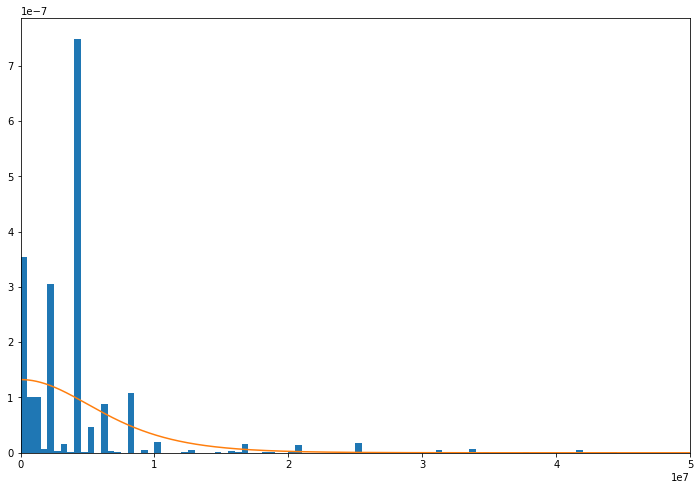

In [33]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_halflogistic)

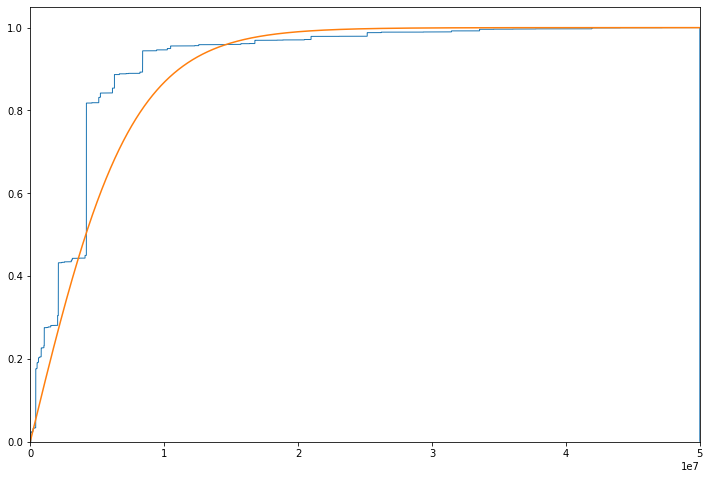

In [34]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_halflogistic)

In [35]:
loc_logistic, scale_logistic = ss.logistic.fit(mem_req)
loc_logistic, scale_logistic

(3511178.443846162, 2769285.7608062048)

In [36]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_logistic = ss.logistic.pdf(x, loc=loc_logistic, scale=scale_logistic)
y_cdf_logistic = ss.logistic.cdf(x, loc=loc_logistic, scale=scale_logistic)

In [46]:
a_invgamma, loc_invgamma, scale_invgamma = ss.invgamma.fit(mem_req)
a_invgamma, loc_invgamma, scale_invgamma

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(2.171118312647865, -1115221.0646614549, 6977580.886652773)

In [47]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_invgamma = ss.invgamma.pdf(x, a=a_invgamma, loc=loc_invgamma, scale=scale_invgamma)
y_cdf_invgamma = ss.invgamma.cdf(x, a=a_invgamma, loc=loc_invgamma, scale=scale_invgamma)

In [98]:
a_beta, b_beta, loc_beta, scale_beta = ss.beta.fit(mem_req)
a_beta, b_beta, loc_beta, scale_beta

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.741761813043437, 1268.3545673823392, -5794.74031477439, 8886789790.851982)

In [99]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_beta = ss.beta.pdf(x, a=a_beta, b=b_beta, loc=loc_beta, scale=scale_beta)
y_cdf_beta = ss.beta.cdf(x, a=a_beta, b=b_beta, loc=loc_beta, scale=scale_beta)

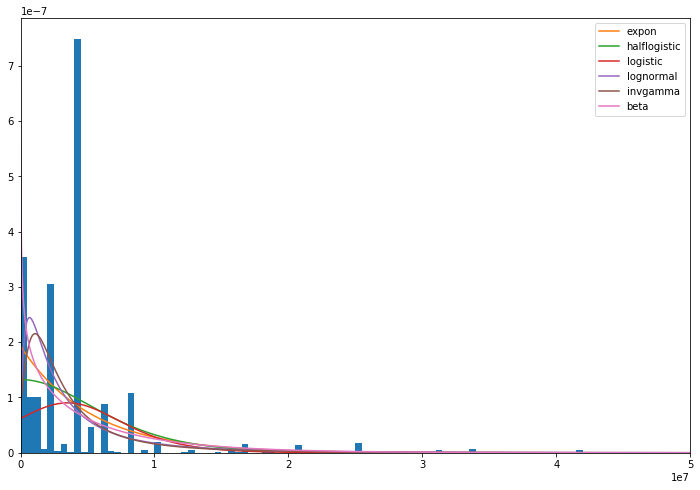

In [100]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_expon, label='expon')
ax.plot(x, y_pdf_halflogistic, label='halflogistic')
ax.plot(x, y_pdf_logistic, label='logistic')
ax.plot(x, y_pdf_lognorm, label='lognormal')
ax.plot(x, y_pdf_invgamma, label='invgamma')
ax.plot(x, y_pdf_beta, label='beta')
ax.legend()

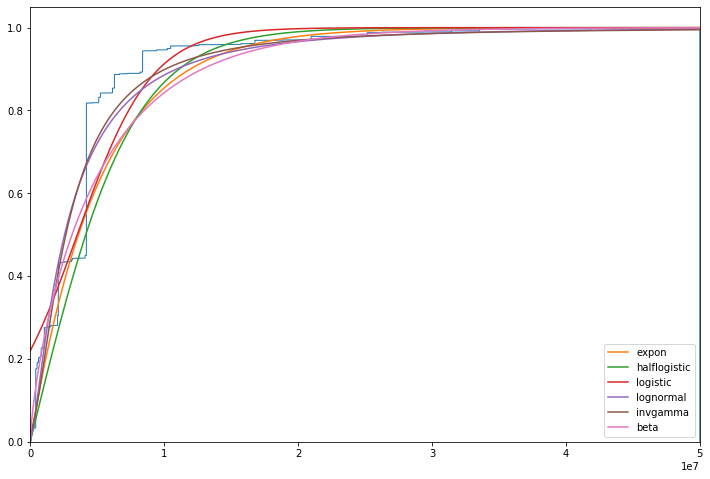

In [101]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_expon, label='expon')
ax.plot(x, y_cdf_halflogistic, label='halflogistic')
ax.plot(x, y_cdf_logistic, label='logistic')
ax.plot(x, y_cdf_lognorm, label='lognormal')
ax.plot(x, y_cdf_invgamma, label='invgamma')
ax.plot(x, y_cdf_beta, label='beta')
ax.legend()

In [91]:
ss.kstest(mem_req, ss.expon(loc=loc_expon, scale=scale_expon).cdf)

KstestResult(statistic=0.2562073778175842, pvalue=0.0)

In [92]:
ss.kstest(mem_req, ss.logistic(loc=loc_logistic, scale=scale_logistic).cdf)

KstestResult(statistic=0.2489968618711269, pvalue=0.0)

In [93]:
ss.kstest(mem_req, ss.halflogistic(loc=loc_halflogistic, scale=scale_halflogistic).cdf)

KstestResult(statistic=0.30584896812753004, pvalue=0.0)

In [95]:
ss.kstest(mem_req, ss.lognorm(s=s_lognorm, loc=loc_lognorm, scale=scale_lognorm).cdf)

KstestResult(statistic=0.2200437126748323, pvalue=0.0)

In [97]:
ss.kstest(mem_req, ss.invgamma(a=a_invgamma, loc=loc_invgamma, scale=scale_invgamma).cdf)

KstestResult(statistic=0.2265046979697964, pvalue=0.0)

In [102]:
ss.kstest(mem_req, ss.beta(a=a_beta, b=b_beta, loc=loc_beta, scale=scale_beta).cdf)

KstestResult(statistic=0.2233209786047683, pvalue=0.0)

In [86]:
# Kolmogorov-Smirnov is vulnerable to very high values
ss.anderson(mem_req, 'expon')

AndersonResult(statistic=307208.03267262504, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [46]:
ss.anderson(mem_req, 'logistic')

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


AndersonResult(statistic=inf, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]))

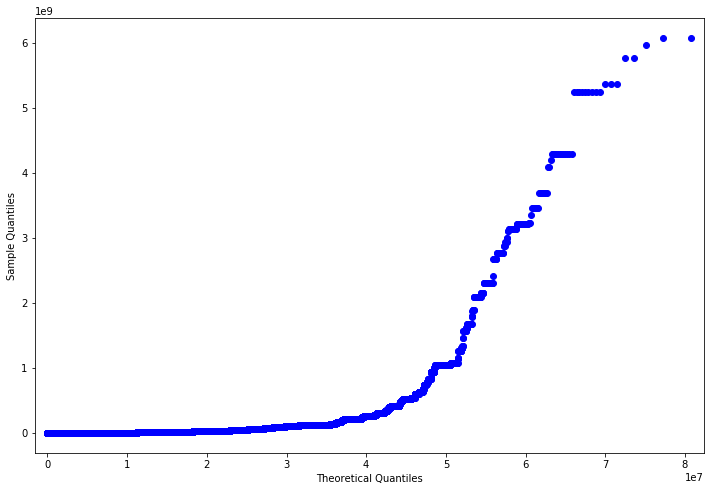

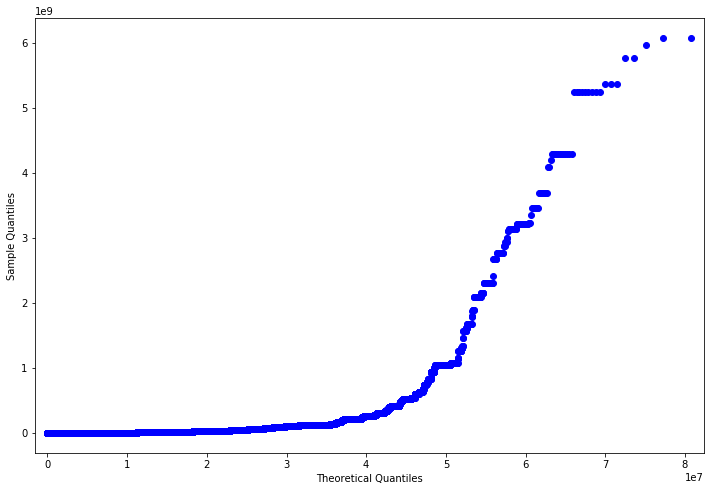

In [52]:
sm.ProbPlot(mem_req, dist=ss.expon, loc=loc_expon, scale=scale_expon).qqplot()

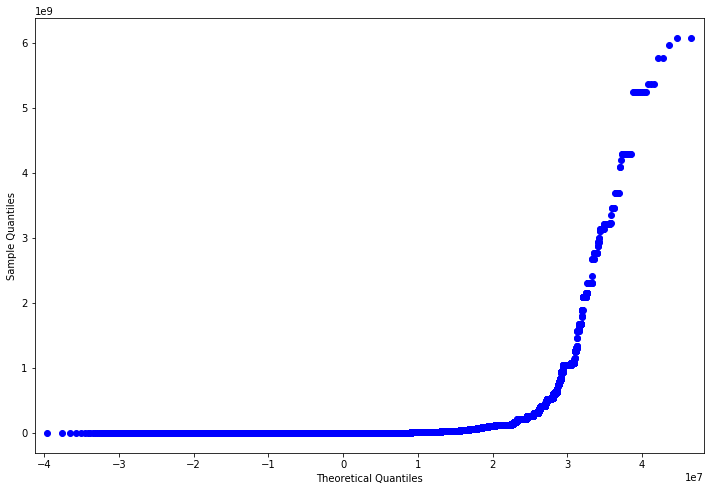

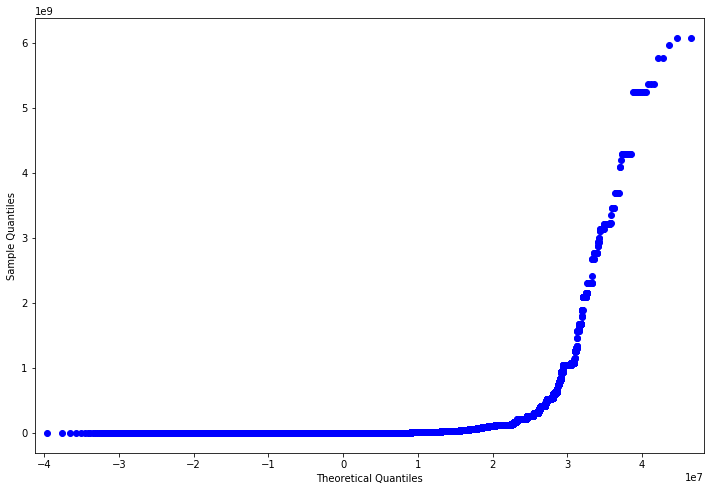

In [53]:
sm.ProbPlot(mem_req, dist=ss.logistic, loc=loc_logistic, scale=scale_logistic).qqplot()

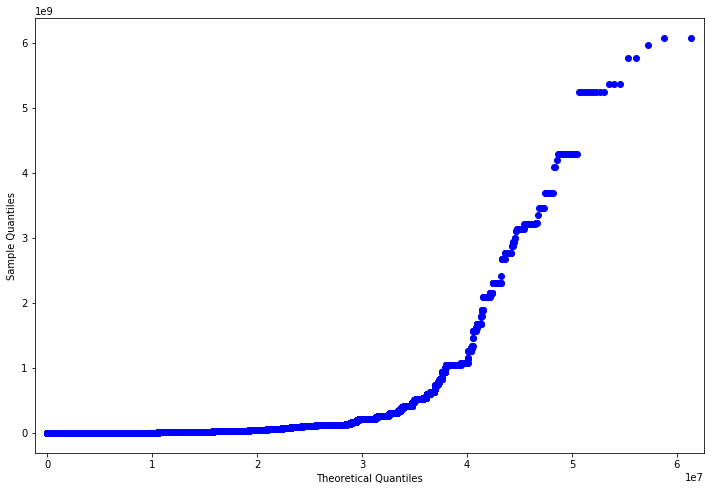

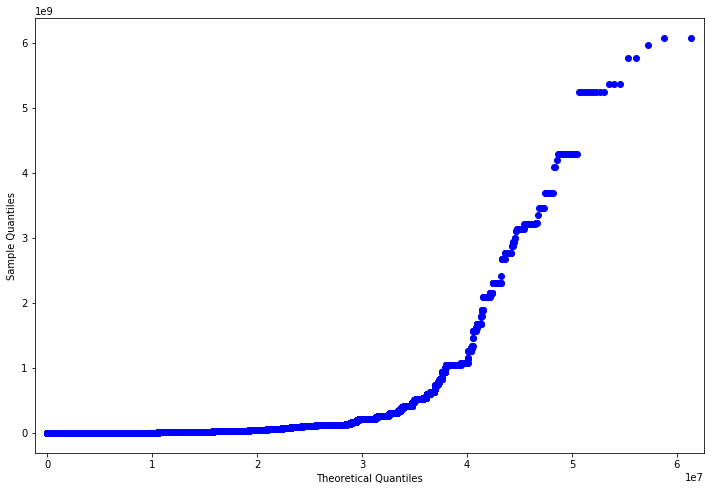

In [54]:
sm.ProbPlot(mem_req, dist=ss.halflogistic, loc=loc_halflogistic, scale=scale_halflogistic).qqplot()

In [15]:
loc_expon, scale_expon = (1.0, 5192451.526500191)
loc_halflogistic, scale_halflogistic = (0.9999957379964148, 3776381.9680622933)
loc_logistic, scale_logistic = (3511178.443846162, 2769285.7608062048)

In [16]:
expon = ss.expon(loc=loc_expon, scale=scale_expon)
halflogistic = ss.halflogistic(loc=loc_halflogistic, scale=scale_halflogistic)
logistic = ss.logistic(loc=loc_logistic, scale=scale_logistic)

In [18]:
print(expon.mean())
print(expon.var())
print(expon.std())
print(expon.median())

5192452.526500191
26961552855054.16
5192451.526500191
3599134.135787791


In [19]:
print(halflogistic.mean())
print(halflogistic.var())
print(halflogistic.std())
print(halflogistic.median())

5235178.02775533
19509930863692.883
4417004.7389257895
4148780.6368136345


In [20]:
print(logistic.mean())
print(logistic.var())
print(logistic.std())
print(logistic.median())

3511178.443846162
25229813251015.223
5022928.752333167
3511178.443846162


In [35]:
distributions = pd.DataFrame(columns=['left', 'right', 'loc', 'scale'])
loc, scale = ss.logistic.fit(df[df.proc_req == 1]['mem_req'])
distributions.loc[0] = [1, 1, loc, scale]
for i in range(1, 10):
    print(i)
    left = 2**(i-1)
    right = 2**i
    loc, scale = ss.logistic.fit(df[(df.proc_req > left) & (df.proc_req <= right)]['mem_req'])
    distributions.loc[i] = [left, right, loc, scale]
print(10)
loc, scale = ss.logistic.fit(df[df.proc_req > 2**9]['mem_req'])
distributions.loc[10] = [2**9, None, loc, scale]

1
4105668.7957870327 3527034.432681147
2
3659916.6514301915 1802083.529238596
3
5175922.413399733 5941373.517211487
4
15455227.638272129 15342083.78279363
5
31334190.905926846 30933817.47274697
6
44690430.14614655 44542752.83635436
7
83376258.34207457 140265817.5652222
8
131286987.33615085 207193948.94404787
9
401220444.27939266 479017421.1907239
10


In [36]:
distributions

,left,right,loc,scale
0,1.0,1.0,3.215569e+06,1.603255e+06
1,1.0,2.0,4.105669e+06,3.527034e+06
2,2.0,4.0,3.659917e+06,1.802084e+06
3,4.0,8.0,5.175922e+06,5.941374e+06
4,8.0,16.0,1.545523e+07,1.534208e+07
5,16.0,32.0,3.133419e+07,3.093382e+07
6,32.0,64.0,4.469043e+07,4.454275e+07
7,64.0,128.0,8.337626e+07,1.402658e+08
8,128.0,256.0,1.312870e+08,2.071939e+08
9,256.0,512.0,4.012204e+08,4.790174e+08


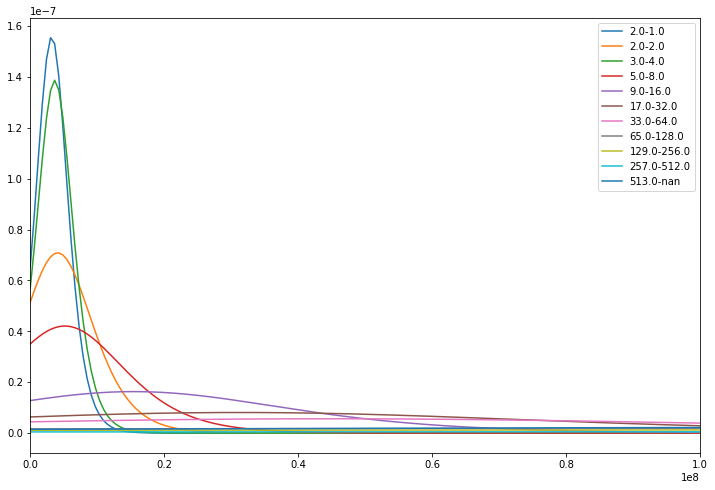

In [66]:
x = np.linspace(mem_req.min(), mem_req.max(), 10000)
fig, ax = plt.subplots()
ax.set_xlim(right=10**8)
# ax.hist(mem_req, bins=1000, density=True, log=True)
for i in range(11):
    dist = distributions.loc[i]
    y_pdf = ss.logistic.pdf(x, loc=dist['loc'], scale=dist['scale'])
    ax.plot(x, y_pdf, label='{}-{}'.format(dist['left']+1, dist['right']))
ax.legend()

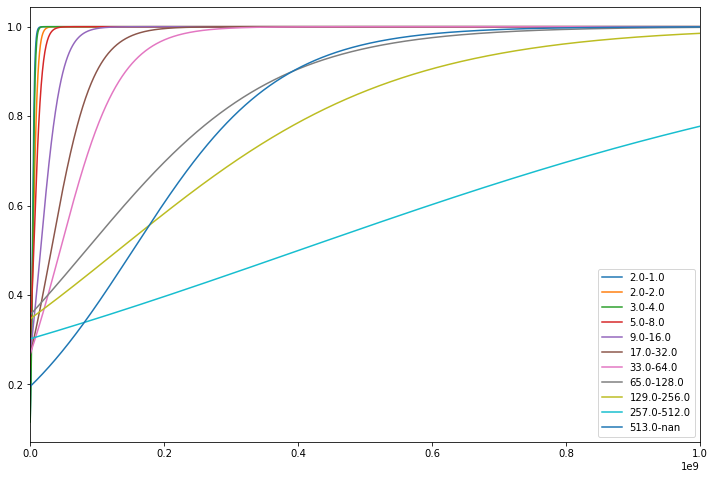

In [73]:
x = np.linspace(mem_req.min(), mem_req.max(), 10000)
fig, ax = plt.subplots()
ax.set_xlim(right=10**9)
# ax.hist(mem_req, bins=1000, density=True, log=True)
for i in range(11):
    dist = distributions.loc[i]
    y_cdf = ss.logistic.cdf(x, loc=dist['loc'], scale=dist['scale'])
    ax.plot(x, y_cdf, label='{}-{}'.format(dist['left']+1, dist['right']))
ax.legend()

In [131]:
mem_small = df[df.proc_req < 64]['mem_req']
mem_large = df[df.proc_req >= 64]['mem_req']

In [132]:
mem_small.shape

(5716155,)

In [133]:
mem_large.shape

(5936,)

In [99]:
fit_small_sample = mem_small.sample(n=10000)

In [13]:
fitter_large = Fitter(mem_large)
fitter_large.fit()

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted alpha distribution with error=4.9051762776429945e-17)
Fitted anglit distribution with error=6.441479151042368e-17)
Fitted arcsine distribution with error=5.671816696399145e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7953: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:712:

Fitted argus distribution with error=6.737880415845151e-17)
Fitted beta distribution with error=2.007470363094309e-17)
Fitted betaprime distribution with error=2.2144172725981398e-17)
Fitted bradford distribution with error=3.7486386157043186e-17)
Fitted burr distribution with error=1.7170912406558387e-17)
Fitted burr12 distribution with error=3.874661740109108e-17)
Fitted cauchy distribution with error=3.1466656523332853e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:951: RuntimeWarning: overflow encountered in power
  return np.log(c) + np.log(d) + sc.xlogy(c - 1, x) + sc.xlog1py(-d-1, x**c)


Fitted chi distribution with error=2.8515988429813827e-17)
Fitted chi2 distribution with error=2.9535407173555943e-17)
Fitted cosine distribution with error=6.479234957292296e-17)
Fitted crystalball distribution with error=5.742497490257571e-17)
Fitted dgamma distribution with error=2.145530972560991e-17)
Fitted dweibull distribution with error=4.051739218640679e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/s

Fitted erlang distribution with error=1.9395487275686807e-17)
Fitted expon distribution with error=2.4779417341955147e-17)
Fitted exponnorm distribution with error=2.464653777438877e-17)
Fitted exponpow distribution with error=3.1577506275108844e-17)
Fitted exponweib distribution with error=2.4109832800273865e-17)
Fitted f distribution with error=1.314525267860207e-17)
Fitted fatiguelife distribution with error=1.498354321148791e-17)
Fitted fisk distribution with error=1.3070303295072277e-17)
Fitted foldcauchy distribution with error=6.851126010071089e-17)
Fitted foldnorm distribution with error=5.1485398226817275e-17)
Fitted frechet_l distribution with error=6.886970656543098e-17)
Fitted frechet_r distribution with error=1.8974458183550232e-17)
Fitted gamma distribution with error=2.85006052680109e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=2.5646950456836202e-17)
Fitted genexpon distribution with error=2.477941891470401e-17)
Fitted genextreme distribution with error=6.025738924689988e-17)
Fitted gengamma distribution with error=1.4105053643350443e-17)
Fitted genhalflogistic distribution with error=3.452115674542906e-17)
Fitted geninvgauss distribution with error=1.3770502382663178e-17)
Fitted genlogistic distribution with error=3.904143459909077e-17)
Fitted gennorm distribution with error=4.143616147151027e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=1.2633458373984537e-17)
Fitted gilbrat distribution with error=1.2288993545871332e-17)
Fitted gompertz distribution with error=3.0779766934569244e-17)
Fitted gumbel_l distribution with error=6.364775706948368e-17)
Fitted gumbel_r distribution with error=3.90235622132433e-17)
Fitted halfcauchy distribution with error=1.2952209323117174e-17)
Fitted halfgennorm distribution with error=1.3703811936858598e-17)
Fitted halflogistic distribution with error=3.4511688990744124e-17)
Fitted halfnorm distribution with error=5.148539919839286e-17)
Fitted hypsecant distribution with error=4.131521859681308e-17)
Fitted invgamma distribution with error=2.23022186862673e-17)
Fitted invgauss distribution with error=1.3724030307915698e-17)
Fitted invweibull distribution with error=1.7060969066647934e-17)
Fitted johnsonsb distribution with error=1.3138729446365095e-17)
Fitted johnsonsu distribution with error=1.3100685404565284e-17)
Fitted kappa3 distribution with e

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:97: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=6.608519918729339e-17)
Fitted kstwobign distribution with error=5.102019666370782e-17)
Fitted laplace distribution with error=3.757377083278126e-17)
Fitted levy distribution with error=1.489180791135866e-17)
Fitted levy_l distribution with error=6.78252646554251e-17)
SKIPPED levy_stable distribution (taking more than 30 seconds)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted loggamma distribution with error=5.846953645550918e-17)
Fitted logistic distribution with error=4.5482718640635275e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=1.5010049286307564e-17)
Fitted lognorm distribution with error=1.3095791275891203e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


Fitted loguniform distribution with error=6.878632837677831e-17)
Fitted lomax distribution with error=1.2632620814545154e-17)
Fitted maxwell distribution with error=5.536293818680085e-17)
Fitted mielke distribution with error=1.712550714484239e-17)
Fitted moyal distribution with error=3.4071710875473776e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5544: RuntimeWarning: divide by zero encountered in power
  return 2*nu**nu/sc.gamma(nu)*(x**(2*nu-1.0))*np.exp(-nu*x*x)


Fitted nakagami distribution with error=3.013893273185318e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


Fitted ncf distribution with error=6.88434026261276e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5832: RuntimeWarning: overflow encountered in multiply
  trm1 = np.sqrt(2)*nc*x*sc.hyp1f1(n/2+1, 1.5, valF)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5836: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2


SKIPPED nct distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
Fitted norm distribution with error=5.802906120492576e-17)
Fitted norminvgauss distribution with error=6.878632837677831e-17)
Fitted pareto distribution with error=3.933606974642042e-17)
Fitted pearson3 distribution with error=1.3035357395227836e-17)
Fitted powerlaw distribution with error=3.7204208271495426e-17)
SKIPPED powerlognorm distribution (taking more than 30 seconds)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6272: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6272: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


Fitted powernorm distribution with error=nan)
Fitted rayleigh distribution with error=5.4826081427720346e-17)
Fitted rdist distribution with error=5.804767940147589e-17)
Fitted recipinvgauss distribution with error=1.911022596774136e-17)
Fitted reciprocal distribution with error=6.878632837677831e-17)
Fitted rice distribution with error=5.48260811468065e-17)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=6.518703903179042e-17)
Fitted skewnorm distribution with error=5.148673388593687e-17)
Fitted t distribution with error=2.5575925945543193e-17)
Fitted trapz distribution with error=6.995036322109802e-17)
Fitted triang distribution with error=6.216108632781873e-17)
Fitted truncexpon distribution with error=6.349036122534825e-17)
Fitted truncnorm distribution with error=6.878632837677831e-17)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7248: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


Fitted tukeylambda distribution with error=5.831581683977855e-17)
Fitted uniform distribution with error=6.608257181702662e-17)
Fitted vonmises distribution with error=7.703896635203832e-11)
Fitted vonmises_line distribution with error=4.9607729430703166e-17)
Fitted wald distribution with error=1.652257987799643e-17)
Fitted weibull_max distribution with error=6.886970656543098e-17)
Fitted weibull_min distribution with error=1.8974458183550232e-17)
Fitted wrapcauchy distribution with error=nan)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [14]:
pd.options.display.max_rows = 100
fitter_large.summary(Nbest=100, plot=False, method='sumsquare_error')

,sumsquare_error,aic,bic,kl_div
gilbrat,1.228899e-17,5482.562331,-8.223719e+04,inf
kappa3,1.255021e-17,5097.712723,-8.219244e+04,inf
lomax,1.263262e-17,5073.839483,-8.218084e+04,inf
genpareto,1.263346e-17,5078.804587,-8.218072e+04,inf
halfcauchy,1.295221e-17,5062.078724,-8.214405e+04,inf
pearson3,1.303536e-17,6404.878752,-8.212523e+04,inf
fisk,1.307030e-17,5017.280813,-8.212049e+04,inf
lognorm,1.309579e-17,5051.558794,-8.211703e+04,inf
johnsonsu,1.310069e-17,5053.549915,-8.210889e+04,inf
johnsonsb,1.313873e-17,5051.127309,-8.210375e+04,inf


In [134]:
small_jobs = workload.df[workload.df.proc_req < 64]
large_jobs = workload.df[workload.df.proc_req >= 64]

In [135]:
small_jobs_proc_time = sum(small_jobs.proc_req * small_jobs.execution_time)
large_jobs_proc_time = sum(large_jobs.proc_req * large_jobs.execution_time)
all_jobs_proc_time = sum(workload.df.proc_req * workload.df.execution_time)
print(small_jobs_proc_time / all_jobs_proc_time)
print(large_jobs_proc_time / all_jobs_proc_time)

0.8902183934610101
0.10978160653898998


In [136]:
small_jobs_mem_time = sum(small_jobs.mem_req * small_jobs.execution_time)
large_jobs_mem_time = sum(large_jobs.mem_req * large_jobs.execution_time)
all_jobs_mem_time = sum(workload.df.mem_req * workload.df.execution_time)
print(small_jobs_mem_time / all_jobs_mem_time)
print(large_jobs_mem_time / all_jobs_mem_time)

0.9156683718465923
0.08433162815340761


In [152]:
# Expotential
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    loc, scale = ss.expon.fit(fit_data)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.expon(loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(locs)
print(scales)
print(kstests)
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0
1
2
3
4
[1.0, 1.0, 1.0, 1.0, 1.0]
[5198107.505906714, 5193295.154979179, 5192619.88819647, 5191517.652379932, 5186717.432274214]
[0.25676050600537526, 0.25594970932145156, 0.2564734743922469, 0.2561785656405834, 0.25567410428670234]
1.0
5192451.526747302
0.2562072719292719
0.0
4076.828276467476
0.0004267206279571399


In [154]:
# Logistic
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    loc, scale = ss.logistic.fit(fit_data)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.logistic(loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(locs)
print(scales)
print(kstests)
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0
1
2
3
4
[3509451.0303349197, 3511670.758279657, 3510636.5905107856, 3511045.0151225533, 3513087.3692613686]
[2763829.694030475, 2773737.7166178594, 2767415.548603923, 2767903.529424989, 2773544.746372251]
[0.24821919444191287, 0.24916878808725895, 0.2488098782211947, 0.2491994670498845, 0.24958569728059787]
3511178.152701857
2769286.2470098995
0.24899660501616977
1339.937966716108
4275.973262099188
0.0005140680420989287


In [155]:
# Half-Logistic
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    loc, scale = ss.halflogistic.fit(fit_data)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.halflogistic(loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(locs)
print(scales)
print(kstests)
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0
1
2
3
4
[0.9999999926271355, 0.9999999580758148, 0.9999994217626422, 0.9999999873721123, 0.9999999931316215]
[3776451.090026945, 3772362.6848535077, 3723234.5392880472, 3785026.9271756867, 3774889.3137025554]
[0.3054050952405174, 0.305396798395969, 0.29989777988719035, 0.30777129611054155, 0.305237168097803]
0.9999998705938652
3766392.9110093485
0.30474162754640427
2.5132018321464464e-07
24590.98224831069
0.0029050279867638756


In [156]:
# Lognormal
sparams = []
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    s, loc, scale = ss.lognorm.fit(fit_data)
    sparams.append(s)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.lognorm(s=s, loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(sparams)
print(locs)
print(scales)
print(kstests)
print(mean(sparams))
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(sparams))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0
1
2
3
4
[1.0965685063341284, 1.0977166833911371, 1.0969802792726804, 1.0969419340680857, 1.098050898958355]
[-150737.36370471987, -150075.44691417392, -150625.7344450991, -150414.30354835518, -149955.12757946365]
[2714361.7951444834, 2712384.174721071, 2714805.379710704, 2716049.5297597214, 2712976.982961324]
[0.2204351500207941, 0.221092575720024, 0.21974458017407922, 0.21868010343976957, 0.2202661544344897]
1.0972516604048774
-150361.59523836235
2714115.5724594607
0.22004371275783133
0.0006105952526246159
339.4283606127165
1463.7942706787073
0.000901627364654745


In [158]:
# Beta
aparams = []
bparams = []
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    a, b, loc, scale = ss.beta.fit(fit_data)
    aparams.append(a)
    bparams.append(b)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.beta(a=a, b=b, loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(aparams)
print(bparams)
print(locs)
print(scales)
print(kstests)
print(mean(aparams))
print(mean(bparams))
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(aparams))
print(stdev(bparams))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1
2
3
4
[0.7663863847055816, 0.7693586884039993, 3.8649192186704013, 0.7602486569399884, 1.3491673624199922]
[3491.511278114999, 4740.512151335555, 142087.9214978459, 2422.040652718356, 5781.458605741071]
[0.9976356293934117, 0.5991978340208857, -2611206.828278348, 0.8307340142668307, -14571.926264643385]
[23759570612.37539, 32110468390.696, 222618370817.2956, 16725421058.91175, 15744195161.3947]
[0.22808172824804362, 0.22839685837633616, 0.21013749112776298, 0.2293918490682042, 0.22745119225338462]
1.5020160622279926
31704.688837151178
-525155.2653951027
62191605208.13469
0.2246918238147463
1.3448820380591553
61719.11295391123
1166155.3474155548
89921047314.23674
0.00816626727299797


In [161]:
# Gamma
aparams = []
locs = []
scales = []
kstests = []
kf = KFold(n_splits=5, shuffle=True)
for i, (fit_index, test_index) in enumerate(kf.split(mem_req)):
    print(i)
    fit_data = mem_req.iloc[fit_index]
    test_data = mem_req.iloc[test_index]
    a, loc, scale = ss.invgamma.fit(fit_data)
    aparams.append(a)
    locs.append(loc)
    scales.append(scale)
    ksresult = ss.kstest(test_data, ss.invgamma(a=a, loc=loc, scale=scale).cdf)
    kstests.append(ksresult.statistic)
print(aparams)
print(locs)
print(scales)
print(kstests)
print(mean(aparams))
print(mean(locs))
print(mean(scales))
print(mean(kstests))
print(stdev(aparams))
print(stdev(locs))
print(stdev(scales))
print(stdev(kstests))

0


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1
2
3
4
[2.172267889668717, 2.1682578364846306, 2.172597421812061, 2.1712956417040843, 2.171177714251337]
[-1115918.3486170424, -1113647.6089387638, -1116228.460553102, -1115546.1171067688, -1114766.857049263]
[6983493.655736341, 6963982.337615041, 6985565.454326963, 6979564.810418356, 6975329.079380849]
[0.22655832311893565, 0.22645536895633311, 0.22579809279715163, 0.22661034374067357, 0.2271013456652855]
2.171119300784166
-1115221.478452988
6977587.06749551
0.2265046948556759
0.0017122050395265147
1035.468142865429
8553.377894059888
0.00046683760013146314


In [191]:
expon = ss.expon(loc=1.0, scale=5192451.526747302)
lognorm = ss.lognorm(s=1.0972516604048774, loc=-150361.59523836235, scale=2714115.5724594607)
logistic = ss.logistic(loc=3511178.152701857, scale=2769286.2470098995)
halflogistic = ss.halflogistic(loc=0.9999998705938652, scale=3766392.9110093485)
beta = ss.beta(a=1.5020160622279926, b=31704.688837151178, loc=-525155.2653951027, scale=62191605208.13469)

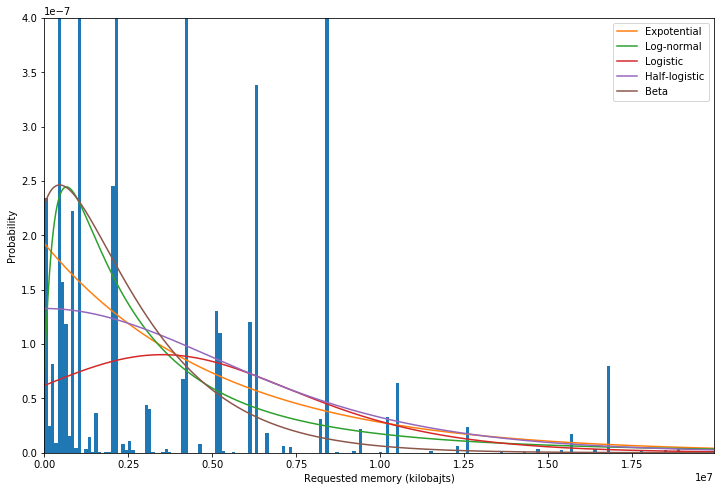

In [237]:
mem_hist_lim = mem_req[mem_req <= 2*10**7]
x = np.linspace(mem_hist_lim.min(), mem_hist_lim.max(), 10000)

fig, ax = plt.subplots()
ax.set_xlim(right=mem_hist_lim.max())
ax.set_ylim(top=0.0000004)
ax.hist(mem_hist_lim, bins=200, density=True)
ax.plot(x, expon.pdf(x), label='Expotential')
ax.plot(x, lognorm.pdf(x), label='Log-normal')
ax.plot(x, logistic.pdf(x), label='Logistic')
ax.plot(x, halflogistic.pdf(x), label='Half-logistic')
ax.plot(x, beta.pdf(x), label='Beta')
ax.set_xlabel('Requested memory (kilobajts)')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('../../images/fitted_pdfs.pdf', bbox_inches='tight')

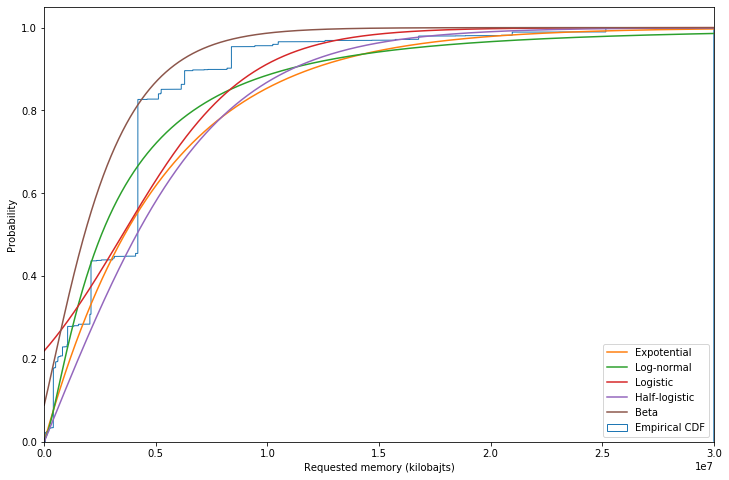

In [238]:
mem_hist_lim = mem_req[mem_req <= 3*10**7]
x = np.linspace(mem_hist_lim.min(), mem_hist_lim.max(), 10000)

fig, ax = plt.subplots()
ax.set_xlim(right=mem_hist_lim.max())
ax.hist(mem_hist_lim, density=True, cumulative=True, bins=10000, histtype='step', label='Empirical CDF')
ax.plot(x, expon.cdf(x), label='Expotential')
ax.plot(x, lognorm.cdf(x), label='Log-normal')
ax.plot(x, logistic.cdf(x), label='Logistic')
ax.plot(x, halflogistic.cdf(x), label='Half-logistic')
ax.plot(x, beta.cdf(x), label='Beta')
ax.set_xlabel('Requested memory (kilobajts)')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('../../images/fitted_cdfs.pdf', bbox_inches='tight')

In [241]:
print(lognorm.mean())
print(lognorm.var())
print(lognorm.std())
print(lognorm.median())

4804884.078088729
57292789985195.95
7569200.08885985
2563753.9772210983


In [289]:
from scipy.optimize import minimize
minimize(lambda x: -10**10*lognorm.pdf(x), 6*10**5)

      fun: -2445.7456128972785
 hess_inv: array([[1.09575774e+09]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 3
     njev: 18
   status: 0
  success: True
        x: array([665852.55325476])